In [43]:
from pathlib import Path

import json
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('seaborn-v0_8')
from scipy.signal import savgol_filter

from dql.utils.namespaces import P, LC
from dql.utils.minis import formatRuntime, formattedRuntimeToSeconds, DotDict

Maybe this should live in the `DataManager` class

In [44]:
def _loadData(runID: str) -> tuple[DotDict[str, any], DotDict[str, np.ndarray]]:
    """ Loads the data from the specified run. """
    dataPath = Path(P.data) / runID
    with open(dataPath / 'summary.json', 'r') as f:
        summary = json.load(f)
    actions = np.load(dataPath / 'actions.npy')
    rewards = np.load(dataPath / 'rewards.npy')
    return DotDict(summary), DotDict(actions = actions, rewards = rewards)

def loadData(runID: str) -> tuple[DotDict[str, any], DotDict[str, np.ndarray]]:
    """
    Concatenates the data for the specified runID.
    Right now only works for 2 runs with the same runID (saved as x and x2).
    """
    s1, d1 = _loadData(runID)
    s2, d2 = _loadData(runID + '2')
    
    s1R, s1A = s1.avgReward, s1.avgActionBias
    s2R, s2A = s2.avgReward, s2.avgActionBias
    s1nR, s2nR = s1.numRepetitions, s2.numRepetitions
    
    summary = s1.copy()
    summary.update(dict(
        numRepetitions = s1nR + s2nR,
        runtime = formatRuntime(formattedRuntimeToSeconds(s1.runtime) + formattedRuntimeToSeconds(s2.runtime)),
        avgReward = (s1R * s1nR + s2R * s2nR) / (s1nR + s2nR),
        avgActionBias = (s1A * s1nR + s2A * s2nR) / (s1nR + s2nR),
    ))

    actions = np.concatenate((d1['actions'], d2['actions']), axis=0)
    rewards = np.concatenate((d1['rewards'], d2['rewards']), axis=0)

    return DotDict(summary), DotDict(actions = actions, rewards = rewards)

## Experiment 1

Load data

In [45]:
summary, data = DotDict(), DotDict()
for runID in ['base', 'replay', 'target', 'target-replay']:
    summary[runID], data[runID] = loadData(runID)

smoothingWindow = summary.base.numEpisodes // 10 + 1
numRepetitions = summary.base.numRepetitions

Rewards per episode

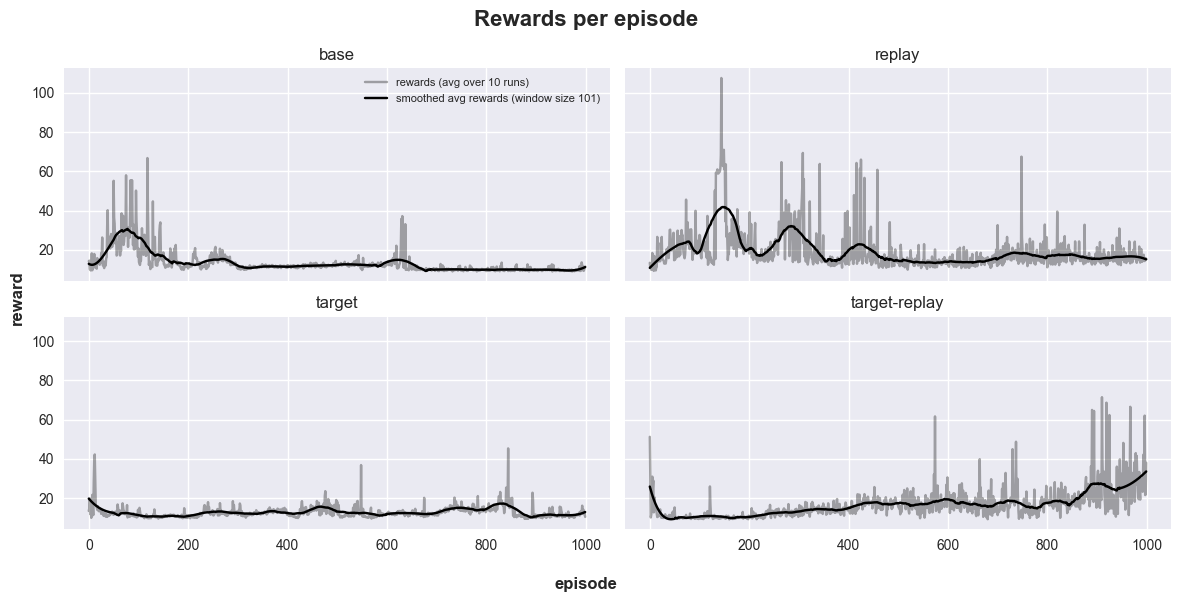

In [46]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True)

for ax, (runID, rewards) in zip([ax1, ax2, ax3, ax4], [(k, v.rewards) for k, v in data.items()]):
    ax.plot(np.mean(rewards, axis=0), alpha=.33, color='k', label=f'rewards (avg over {numRepetitions} runs)')
    
    smoothed = savgol_filter(np.mean(rewards, axis=0), smoothingWindow, 3)
    ax.plot(smoothed, color='k', label=f'smoothed avg rewards (window size {smoothingWindow})')
    ax.set_title(runID)
    if ax == ax1:
        ax.legend(fontsize=8)

fig.suptitle('Rewards per episode', fontsize=16, weight='bold')
fig.supxlabel('episode', fontsize=12, weight='bold')
fig.supylabel('reward', fontsize=12, weight='bold')

fig.tight_layout()
fig.savefig(f'{P.plots}/exp1r.pdf', dpi=500);

Action biases

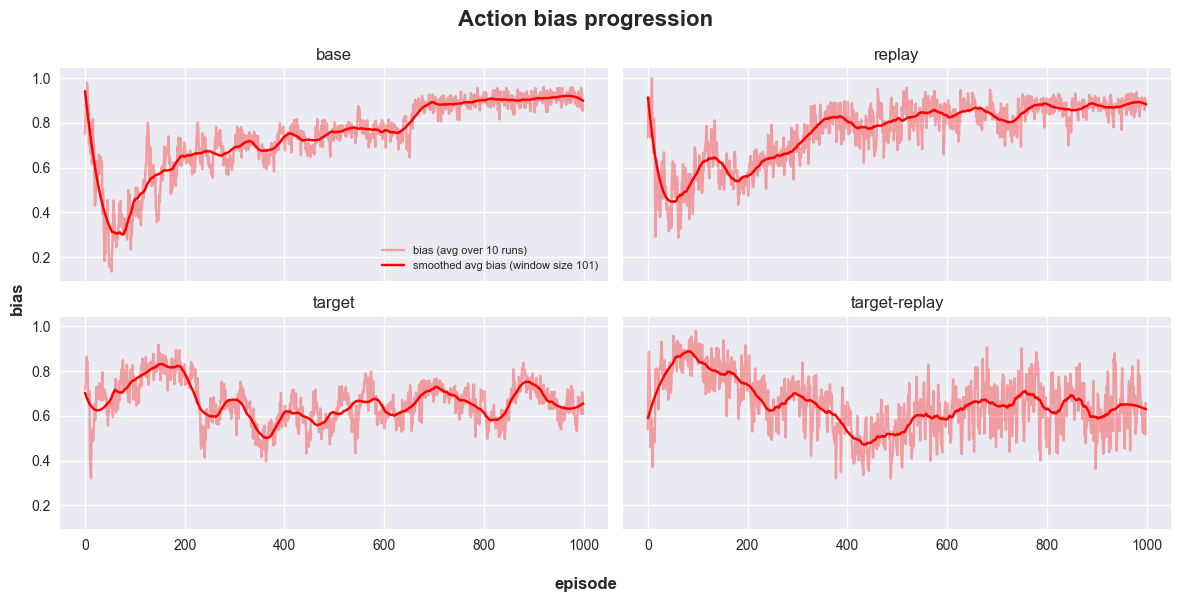

In [47]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True)

for ax, (runID, actions) in zip([ax1, ax2, ax3, ax4], [(k, v.actions) for k, v in data.items()]):
    normAction0 = (actions / np.sum(actions, axis=2, keepdims=True))[:, :, 0]
    bias = np.abs(normAction0 - .5) * 2
    ax.plot(np.mean(bias, axis=0), alpha=.33, color='r', label=f'bias (avg over {numRepetitions} runs)')

    smoothed = savgol_filter(np.mean(bias, axis=0), smoothingWindow, 3)
    ax.plot(smoothed, color='r', label=f'smoothed avg bias (window size {smoothingWindow})')
    ax.set_title(runID)
    if ax == ax1:
        ax.legend(fontsize=8)

fig.suptitle('Action bias progression', fontsize=16, weight='bold')
fig.supxlabel('episode', fontsize=12, weight='bold')
fig.supylabel('bias', fontsize=12, weight='bold')

fig.tight_layout()
fig.savefig(f'{P.plots}/exp1a.pdf', dpi=500);

## Experiment 2

Load data

In [48]:
summary, data = DotDict(), DotDict()
for runID in ['e-greedy', 'boltzmann', 'ucb']:
    summary[runID], data[runID] = _loadData(runID)

smoothingWindow = summary['e-greedy'].numEpisodes // 10 + 1
numRepetitions = summary['e-greedy'].numRepetitions

Rewards per episode

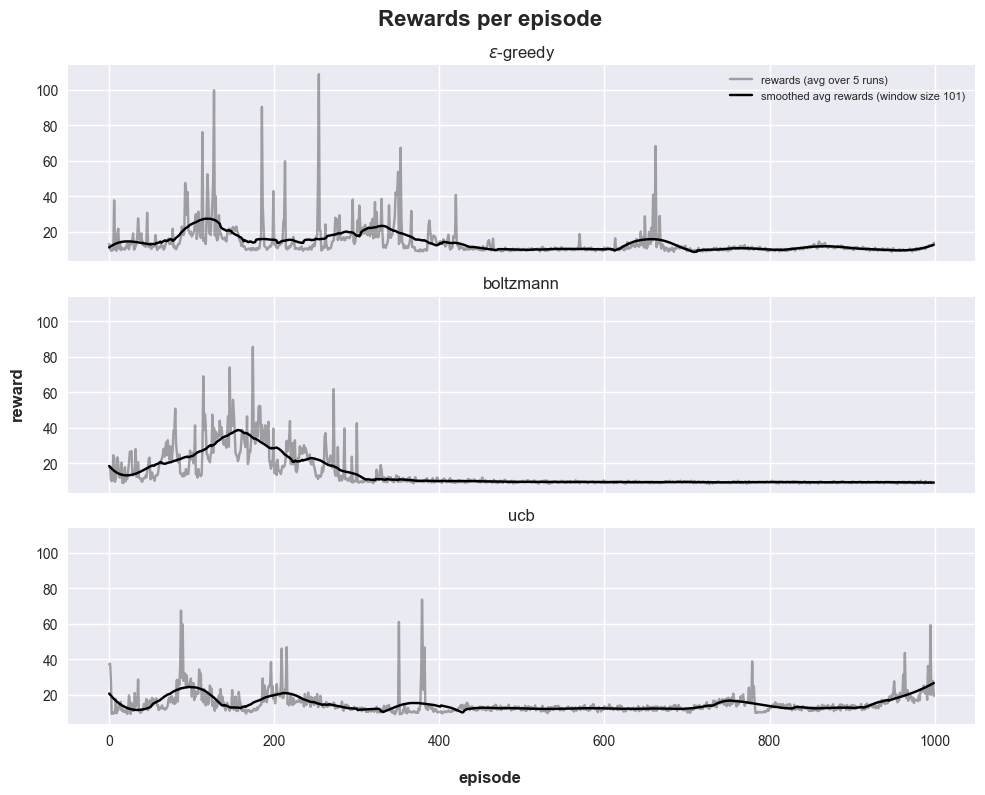

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True, sharey=True)

for ax, (runID, rewards) in zip([ax1, ax2, ax3], [(k, v.rewards) for k, v in data.items()]):
    ax.plot(np.mean(rewards, axis=0), alpha=.33, color='k', label=f'rewards (avg over {summary["e-greedy"].numRepetitions} runs)')
    
    smoothed = savgol_filter(np.mean(rewards, axis=0), smoothingWindow, 3)
    ax.plot(smoothed, color='k', label=f'smoothed avg rewards (window size {smoothingWindow})')
    ax.set_title(runID.replace('e-', f'{LC.e}-'))
    if ax == ax1:
        ax.legend(fontsize=8)

fig.suptitle('Rewards per episode', fontsize=16, weight='bold')
fig.supxlabel('episode', fontsize=12, weight='bold')
fig.supylabel('reward', fontsize=12, weight='bold')

fig.tight_layout()
fig.savefig(f'{P.plots}/exp2r.pdf', dpi=500);

Action biases

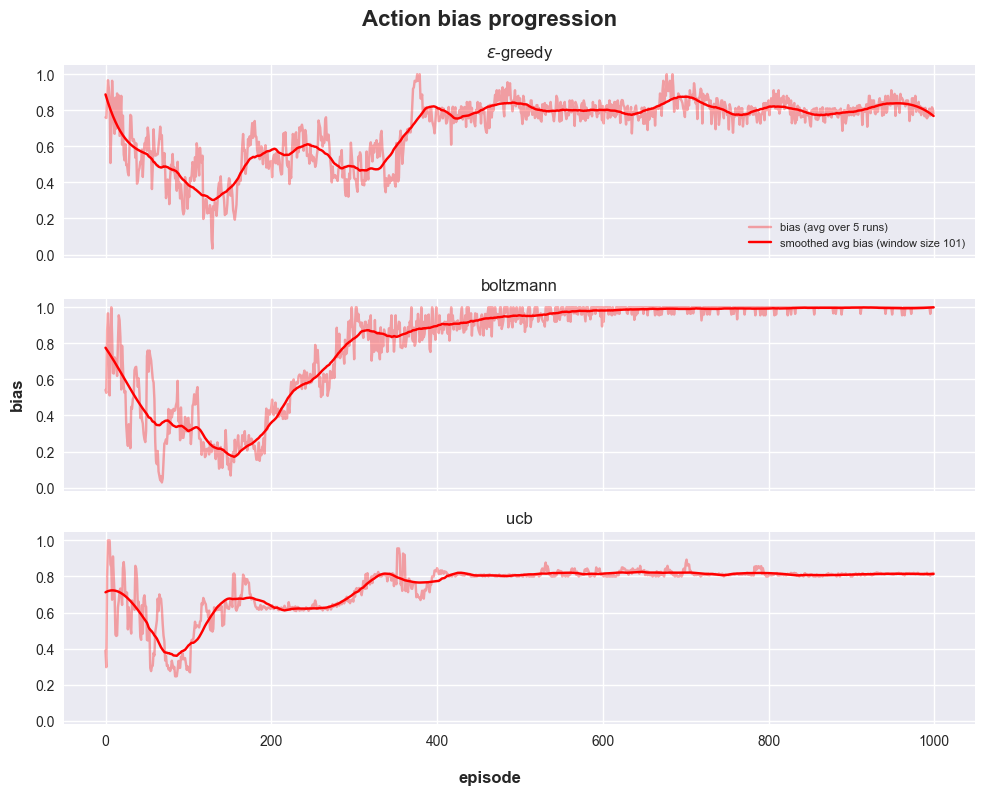

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True, sharey=True)

for ax, (runID, actions) in zip([ax1, ax2, ax3], [(k, v.actions) for k, v in data.items()]):
    normAction0 = (actions / np.sum(actions, axis=2, keepdims=True))[:, :, 0]
    bias = np.abs(normAction0 - .5) * 2
    ax.plot(np.mean(bias, axis=0), alpha=.33, color='r', label=f'bias (avg over {numRepetitions} runs)')

    smoothed = savgol_filter(np.mean(bias, axis=0), smoothingWindow, 3)
    ax.plot(smoothed, color='r', label=f'smoothed avg bias (window size {smoothingWindow})')
    ax.set_title(runID.replace('e-', f'{LC.e}-'))
    if ax == ax1:
        ax.legend(fontsize=8)

fig.suptitle('Action bias progression', fontsize=16, weight='bold')
fig.supxlabel('episode', fontsize=12, weight='bold')
fig.supylabel('bias', fontsize=12, weight='bold')

fig.tight_layout()
fig.savefig(f'{P.plots}/exp2a.pdf', dpi=500);